In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tkinter as tk

In [15]:
#Carregar dados
data_set = pd.read_excel('Base_dados_103_clean.xlsx')
data_set.head()

,Outside temperature (x10)(ºC),Temperature 103 (x10)(ºC),Humidity 103 (x10)(%),Heat Index 103 (x10)(ºC),Occupation,AC status 103 (bool)
0,177,189,588,174.884999,0,0
1,177,189,587,174.881376,0,0
2,177,189,588,174.884999,0,0
3,177,189,587,174.881376,0,0
4,176,189,587,174.881376,0,0


In [16]:
print("Tamanho base de dados original:", len(data_set))

Tamanho base de dados original: 103949


In [17]:
#Oversampling 
X = data_set[['Outside temperature (x10)(ºC)', 'Temperature 103 (x10)(ºC)', 'Humidity 103 (x10)(%)', 'Heat Index 103 (x10)(ºC)', 'Occupation ']]
y = data_set['AC status 103 (bool)']

In [18]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [19]:
#Tamanho base de dados após oversampling
print("Tamanho base de dados após oversampling:", len(X_resampled))

Tamanho base de dados após oversampling: 307437


In [38]:
#Divisão dados treino + teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33)

In [39]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM model with chosen kernel (e.g., linear, RBF)
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, cache_size=1000, verbose=True)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

[LibSVM]...............................................................................
*.................................
*...............................................
*..............................
*
optimization finished, #iter = 188014
obj = -360036.645969, rho = 16.571641
nSV = 42562, nBSV = 42297
.
*
optimization finished, #iter = 1393
obj = -1560.563768, rho = -0.227260
nSV = 274, nBSV = 262
.............................
*.......
*............
*.....
*
optimization finished, #iter = 52071
obj = -130904.800936, rho = -24.683297
nSV = 14742, nBSV = 14663
Total nSV = 56570


SVC(C=10, cache_size=1000, random_state=42, verbose=True)

In [43]:
import pickle

# Save the model to a file
model_filename = './modules/ACStatus/svm_model2.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(svm_model, model_file)

model_filename = './modules/ACStatus/scaler2.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(scaler, model_file)   
    

In [40]:
# Predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

87.27

In [41]:
#acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy * 100:.5f}%')

Acurácia do modelo: 92.24287%


Matriz de Confusão:
[[30875  3057     1]
 [ 2670 29219  2070]
 [    0    72 33491]]


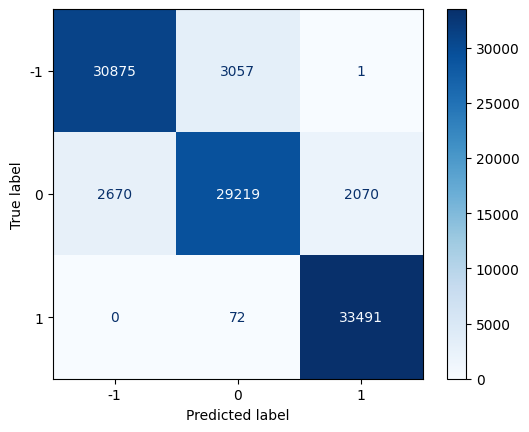

In [45]:
#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
 
import matplotlib.pyplot as plt
class_labels = ['-1', '0', '1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

#Precisão, Recall e F1-Score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precisão: {precision:.10f}')
print(f'Recall: {recall:.10f}')
print(f'F1-score: {f1:.10f}')

Precisão: 0.9217357526
Recall: 0.9224286630
F1-score: 0.9216295434


In [ ]:
from sklearn.model_selection import cross_val_score


#validação cruzada (k-fold com k=5)
scores = cross_val_score(svm_model, X_resampled, y_resampled, cv=5)
#média e o desvio padrão das pontuações da validação cruzada

print(f'Média das pontuações: {scores.mean():.10f}')
print(f'Desvio padrão das pontuações: {scores.std():.10f}')
print("Pontuações da validação cruzada:", scores)

: 

: 

In [48]:
#Previsões com base nos valores de entrada
def predict_ac_status():
    outside_temp = float(entry_outside_temp.get())
    temp_103 = float(entry_temp_103.get())
    humidity_103 = float(entry_humidity_103.get())
    heat_index_103 = float(entry_heat_index_103.get())
    occupation = float(entry_occupation.get())
    scaled = scaler.transform([[outside_temp, temp_103, humidity_103, heat_index_103, occupation]])
    #Previsão com base nos valores inseridos
    prediction = svm_model.predict(scaled)
    print(prediction)
    #Controlar o resultado para "Ligar AC em quente", "Ligar AC em frio" ou "desligar o AC"
    if prediction[0] == -1:
        result_label.config(text="Ligar AC em quente")
    elif prediction[0] == 1:
        result_label.config(text="Ligar AC em frio")
    else:
        result_label.config(text="Desligar o AC")

In [49]:
#Interface
root = tk.Tk()
root.title("Sistema de Controlo do AC")

frame = tk.Frame(root)
frame.pack(padx=20, pady=20)

#Entrada dados
entry_outside_temp = tk.Entry(frame, width=10, justify='center')
entry_temp_103 = tk.Entry(frame, width=10, justify='center')
entry_humidity_103 = tk.Entry(frame, width=10, justify='center')
entry_heat_index_103 = tk.Entry(frame, width=10, justify='center')
entry_occupation = tk.Entry(frame, width=10, justify='center')

entry_outside_temp.grid(row=0, column=1)
entry_temp_103.grid(row=1, column=1)
entry_humidity_103.grid(row=2, column=1)
entry_heat_index_103.grid(row=3, column=1)
entry_occupation.grid(row=4, column=1)

#Título das variáveis
tk.Label(frame, text="Outside Temperature (x10)(ºC)").grid(row=0, column=0)
tk.Label(frame, text="Temperature 103 (x10)(ºC)").grid(row=1, column=0)
tk.Label(frame, text="Humidity (x10)(%)").grid(row=2, column=0)
tk.Label(frame, text="Heat Index 103 (x10)(ºC)").grid(row=3, column=0)
tk.Label(frame, text="Occupation").grid(row=4, column=0)

#'Prever'
predict_button = tk.Button(frame, text="Prever", command=predict_ac_status)
predict_button.grid(row=5, columnspan=2)

#Resultado
result_label = tk.Label(frame, text="")
result_label.grid(row=6, columnspan=2)

root.mainloop()

/home/pardalito/miniconda3/envs/ngs/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[1]


/home/pardalito/miniconda3/envs/ngs/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[1]


/home/pardalito/miniconda3/envs/ngs/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/pardalito/miniconda3/envs/ngs/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[1]
[1]


In [46]:
import pickle
# Load the model from the file
model_filename = './modules/ACStatus/svm_model2.pkl'
with open(model_filename, 'rb') as model_file:
    svm_model = pickle.load(model_file)
    
# Load the model from the file
model_filename = './modules/ACStatus/scaler2.pkl'
with open(model_filename, 'rb') as model_file:
    scaler = pickle.load(model_file)

In [47]:
#Carregar dados
data_set = pd.read_excel('cena.xlsx')
data_set.rename(columns={
    "[Outdoor_temperature_x10]": 'Outside temperature (x10)(ºC)',
    "[N103_Temp_x10]": 'Temperature 103 (x10)(ºC)',
    "[N103_Hum_x10]": 'Humidity 103 (x10)(%)',
    "Heat Index": 'Heat Index 103 (x10)(ºC)',
    "Ocupação": "Occupation "},inplace=True)
data_set.head()
test = scaler.transform(data_set)
test

array([[ 0.57545609,  1.26336793, -0.94043093,  1.21924659, -1.18342671],
       [ 0.57412476,  1.23276583, -0.94297923,  1.19163364, -1.18342671],
       [ 0.57745309,  1.23276583, -0.94170508,  1.19163364, -1.18342671],
       ...,
       [ 0.71125213,  1.33171263, -1.07506649,  1.28086707, -1.18342671],
       [ 0.68728812,  1.32457214, -1.08865746,  1.2744725 , -1.18342671],
       [ 0.68129712,  1.32457214, -1.09035633,  1.2744725 , -1.18342671]])

In [48]:
svm_model.predict(test)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [49]:
# Previsão com base nos valores inseridos
outside_temp = float(237)
temperature = float(248)
heat_index = float(250)
humidity = float(500)
occupation = int(1)
svm_model.predict(scaler.transform([[outside_temp, temperature, humidity, heat_index, occupation]]))

/home/pardalito/miniconda3/envs/ngs/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1])